In [1963]:
import pandas as pd
pd.set_option('display.max_columns', 500)

df = pd.read_csv('cleaned_train.csv')



In [1966]:
df.drop(['weight'], axis=1, inplace=True)
df['response%'] = df['response'] / df['fare_amount']

## jfk

In [1967]:
pickup_mask = (df["pickup_longitude"] > -73.79) &  (df["pickup_longitude"] < -73.76 ) &  (df["pickup_latitude"] > 40.6 ) &  (df["pickup_latitude"] <40.66  )
airport_pickup = df.loc[(df["fare_amount"] == 52) & (pickup_mask)]

JFK_min_long = min(airport_pickup["pickup_longitude"])
JFK_max_long = max(airport_pickup["pickup_longitude"])
JFK_min_lat = min(airport_pickup["pickup_latitude"])
JFK_max_lat = max(airport_pickup["pickup_latitude"])

#airport_pickup_dropoff_mask =  ((df["pickup_longitude"] >= JFK_min_long) & (df["pickup_longitude"] <= JFK_max_long) &  (df["pickup_latitude"] >= JFK_min_lat ) &  (df["pickup_latitude"] <= JFK_max_lat)) |(df["dropoff_longitude"] > JFK_min_long) & (df["dropoff_longitude"] < JFK_max_long) &  (df["dropoff_latitude"] > JFK_min_lat ) &  (df["dropoff_latitude"] <JFK_max_lat)
#manhattan_airport =  ((df["pickup_longitude"] >= JFK_min_long) & (df["pickup_longitude"] <= JFK_max_long) &  (df["pickup_latitude"] >= JFK_min_lat )  &  (df["pickup_latitude"] <= JFK_max_lat) & (df['dropoff_boro_code'] == 'Manhattan')) | ((df["dropoff_longitude"] >= JFK_min_long) & (df["dropoff_longitude"] <= JFK_max_long) &  (df["dropoff_latitude"] >= JFK_min_lat ) &  (df["dropoff_latitude"] <= JFK_max_lat) & (df['pickup_boro_code'] == 'Manhattan')).astype(int)
#airport_dropoff_mask = ((df["dropoff_longitude"] >= JFK_min_long) & (df["dropoff_longitude"] <= JFK_max_long) &  (df["dropoff_latitude"] >= JFK_min_lat ) &  (df["dropoff_latitude"] <= JFK_max_lat)
manhattan_airport2 = ((df['pickup_boro_code'] == 'Manhattan')&(df['dropoff_boro_code'] == 'Queens')&(df['fare_amount'] == 52))|((df['pickup_boro_code'] == 'Queens')&(df['dropoff_boro_code'] == 'Manhattan')&(df['fare_amount'] == 52)) | ((df['pickup_boro_code'] == 'Manhattan')&(df['trip_distance'] < 5)&(df['fare_amount'] == 52))|((df['pickup_boro_code'] == 'Queens')&(df['trip_distance'] < 5)&(df['fare_amount'] == 52))

#data.loc[ (data["fare_amount"] == 52) & airport_pickup_dropoff_mask]
#X["airport"]=(data["fare_amount"] == 52 & airport_pickup_dropoff_mask)

A total of airport rides:

In [1968]:
manhattan_airport2.sum()

6893

In [1969]:
df['manhattan_airport'] = manhattan_airport2.astype(int)

fix the distance for airport rides:

In [1971]:
manhattan_median = df[manhattan_airport2]['trip_distance'].median()
mask = (df['manhattan_airport'] == 1) & (df['trip_distance'] < 8)

# Then, use loc to assign values to the selected rows
df.loc[mask, 'trip_distance'] = manhattan_median

fix the length for airport rides

In [1972]:
manhattan_median_l = df[manhattan_airport2]['length_time'].median()
mask = (df['manhattan_airport'] == 1) & (df['length_time'] <= 1000)

df.loc[mask, 'length_time'] = manhattan_median_l

## convert hoods and nta to clusters

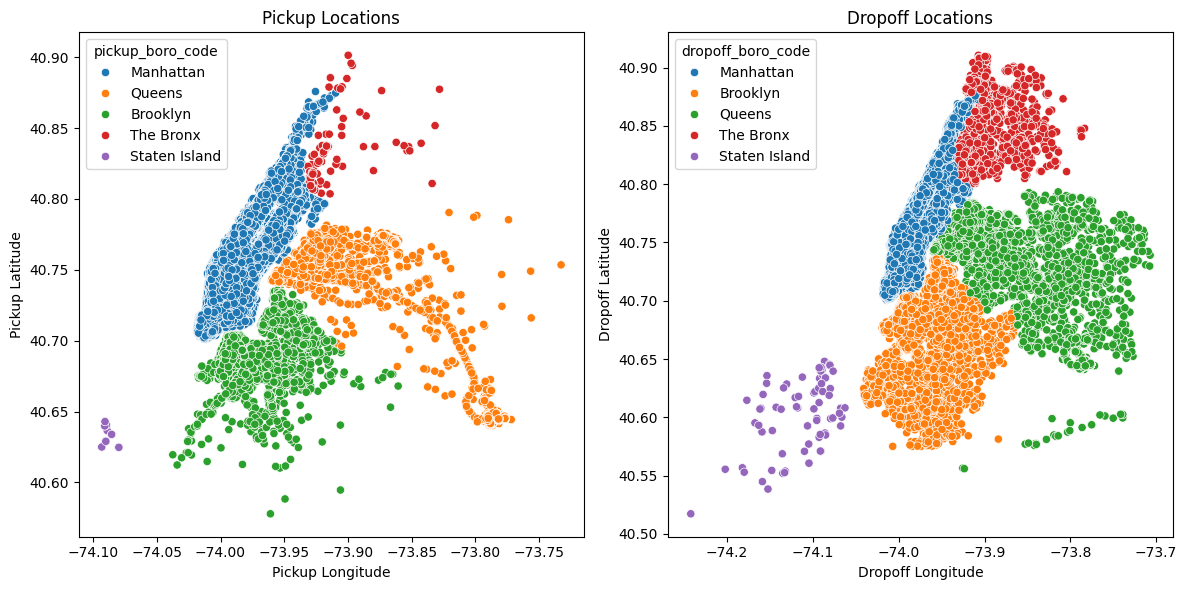

In [1973]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a figure and axes
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Scatter plot for pickup locations
sns.scatterplot(x='pickup_longitude', y='pickup_latitude', hue='pickup_boro_code', data=df, ax=axes[0])
axes[0].set_xlabel('Pickup Longitude')
axes[0].set_ylabel('Pickup Latitude')
axes[0].set_title('Pickup Locations')

# Scatter plot for dropoff locations
sns.scatterplot(x='dropoff_longitude', y='dropoff_latitude', hue='dropoff_boro_code', data=df, ax=axes[1])
axes[1].set_xlabel('Dropoff Longitude')
axes[1].set_ylabel('Dropoff Latitude')
axes[1].set_title('Dropoff Locations')

# Adjust layout
plt.tight_layout()

# Show plots
plt.show()



In [1974]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler


def create_code_clusters(df, n):
    pickup = df[['pickup_latitude', 'pickup_longitude']]
    dropoff = df[['dropoff_latitude', 'dropoff_longitude']]

    pickup_scaler = StandardScaler()
    dropoff_scaler = StandardScaler()
    
    pickup_scaled = pickup_scaler.fit_transform(pickup)
    dropoff_scaled = dropoff_scaler.fit_transform(dropoff)

    pickup_kmeans = KMeans(n_clusters=n, random_state=42)
    dropoff_kmeans = KMeans(n_clusters=n, random_state=45)

    pickup_kmeans.fit(pickup_scaled)
    dropoff_kmeans.fit(dropoff_scaled)

    df['pickup_codes'] = pickup_kmeans.labels_
    df['dropoff_codes'] = dropoff_kmeans.labels_


    return df, pickup_kmeans, dropoff_kmeans, pickup_scaler, dropoff_scaler


In [1975]:
df, pickup_kmeans, dropoff_kmeans, pickup_scaler, dropoff_scaler = create_code_clusters(df, 20)

/Users/kubamalachowski/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/kubamalachowski/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


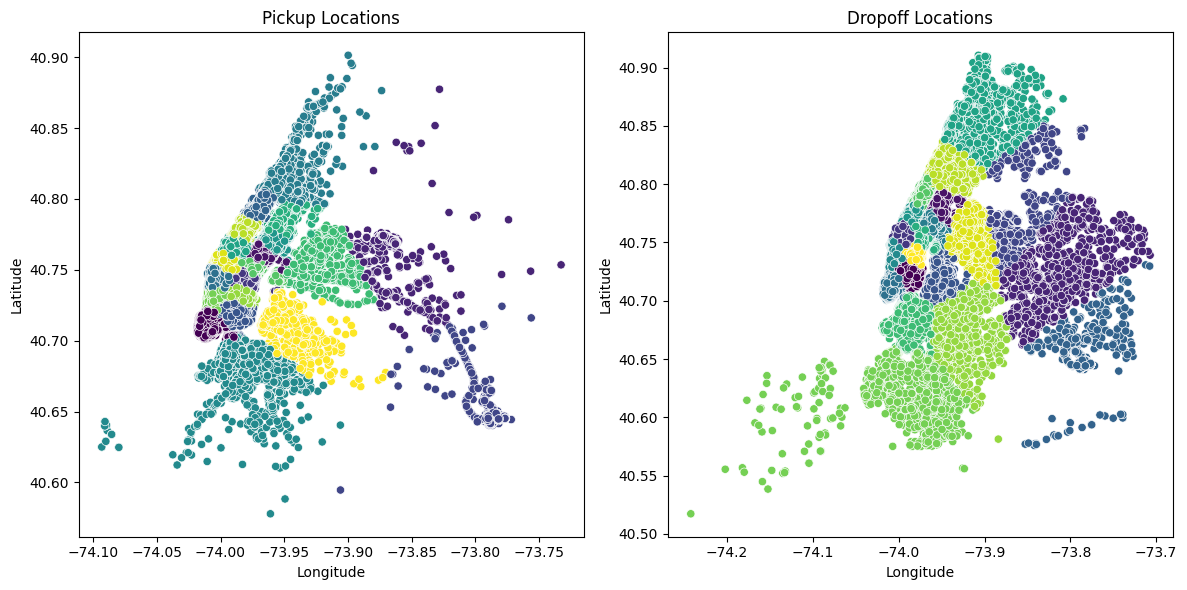

In [1976]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a figure and axes
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Scatter plot for pickup locations
sns.scatterplot(x='pickup_longitude', y='pickup_latitude', hue='pickup_codes', palette='viridis', data=df, ax=axes[0])
axes[0].set_xlabel('Longitude')
axes[0].set_ylabel('Latitude')
axes[0].set_title('Pickup Locations')
axes[0].legend().remove()  # Remove legend to avoid redundancy

# Scatter plot for dropoff locations
sns.scatterplot(x='dropoff_longitude', y='dropoff_latitude', hue='dropoff_codes', palette='viridis', data=df, ax=axes[1])
axes[1].set_xlabel('Longitude')
axes[1].set_ylabel('Latitude')
axes[1].set_title('Dropoff Locations')
axes[1].legend().remove()  # Remove legend to avoid redundancy

# Adjust layout
plt.tight_layout()

# Show plots
plt.show()


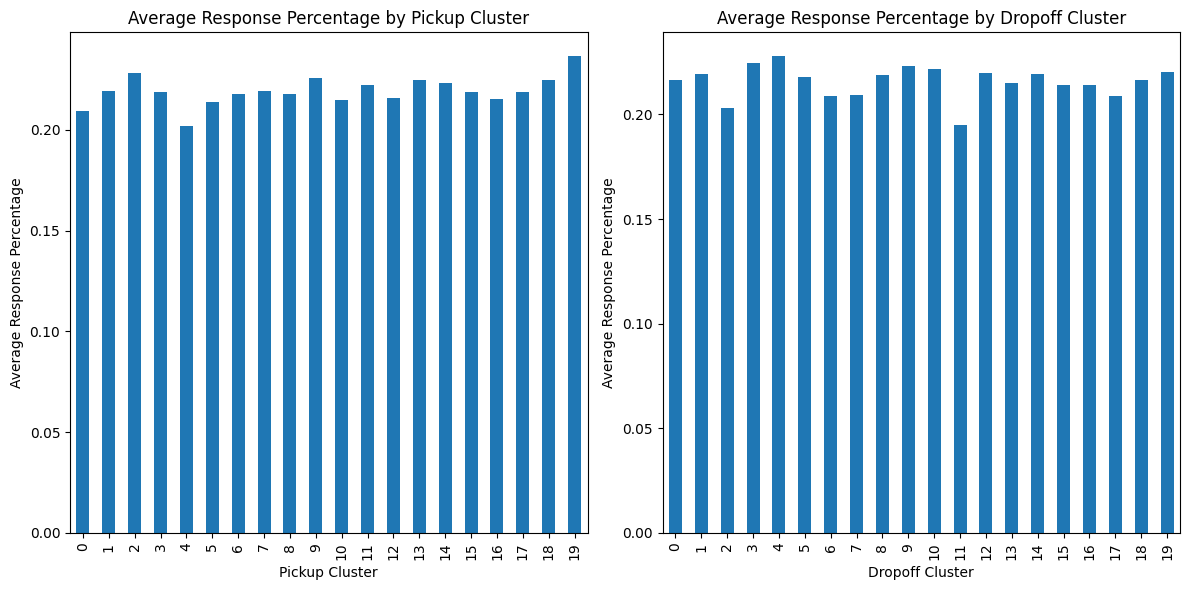

In [1977]:
# average response percentage by pickup cluster and dropoff cluster side by side

# Create a figure and axes
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Average response percentage by pickup cluster
pickup_response = df.groupby('pickup_codes')['response%'].mean()
pickup_response.plot(kind='bar', ax=axes[0])
axes[0].set_xlabel('Pickup Cluster')
axes[0].set_ylabel('Average Response Percentage')
axes[0].set_title('Average Response Percentage by Pickup Cluster')

# Average response percentage by dropoff cluster
dropoff_response = df.groupby('dropoff_codes')['response%'].mean()
dropoff_response.plot(kind='bar', ax=axes[1])
axes[1].set_xlabel('Dropoff Cluster')
axes[1].set_ylabel('Average Response Percentage')
axes[1].set_title('Average Response Percentage by Dropoff Cluster')

# Adjust layout
plt.tight_layout()

# Show plots
plt.show()


In [1979]:
df.drop(['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'pickup_boro_code', 'pickup_nta_code',
       'dropoff_boro_code', 'dropoff_nta_code'], axis=1, inplace=True)

## create dummies for days of week and hours

In [1981]:
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])

# Create dummy variables for day of week
day_of_week_dummies = pd.get_dummies(df['pickup_datetime'].dt.day_name(), prefix='day')

# Create dummy variables for hour of day
hour_dummies = pd.get_dummies(df['pickup_datetime'].dt.hour, prefix='hour')

#code dummies
pickup_dummies = pd.get_dummies(df['pickup_codes'], prefix='pickup')
dropoff_dummies = pd.get_dummies(df['dropoff_codes'], prefix='dropoff')


# Concatenate the dummy variables with the original dataframe
df = pd.concat([df, day_of_week_dummies, hour_dummies, pickup_dummies, dropoff_dummies], axis=1)

#change type
df[day_of_week_dummies.columns] = df[day_of_week_dummies.columns].astype(int)
df[hour_dummies.columns] = df[hour_dummies.columns].astype(int)
df[pickup_dummies.columns] = df[pickup_dummies.columns].astype(int)
df[dropoff_dummies.columns] = df[dropoff_dummies.columns].astype(int)

df.drop(['pickup_datetime', 'pickup_wday', 'pickup_codes', 'dropoff_codes'], axis=1, inplace=True)

In [1982]:
df

,response,length_time,vendor_id,passenger_count,trip_distance,fare_amount,pickup_week,response%,manhattan_airport,day_Friday,day_Monday,day_Saturday,day_Sunday,day_Thursday,day_Tuesday,day_Wednesday,hour_0,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,hour_9,hour_10,hour_11,hour_12,hour_13,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23,pickup_0,pickup_1,pickup_2,pickup_3,pickup_4,pickup_5,pickup_6,pickup_7,pickup_8,pickup_9,pickup_10,pickup_11,pickup_12,pickup_13,pickup_14,pickup_15,pickup_16,pickup_17,pickup_18,pickup_19,dropoff_0,dropoff_1,dropoff_2,dropoff_3,dropoff_4,dropoff_5,dropoff_6,dropoff_7,dropoff_8,dropoff_9,dropoff_10,dropoff_11,dropoff_12,dropoff_13,dropoff_14,dropoff_15,dropoff_16,dropoff_17,dropoff_18,dropoff_19
0,1.75,520,1,1,0.90,7.0,20,0.250000,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1,2.95,824,1,1,1.40,10.0,19,0.295000,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2.46,1016,2,1,1.14,11.5,20,0.213913,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
3,1.66,550,2,1,1.28,7.5,20,0.221333,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
4,1.75,501,1,1,1.40,7.5,19,0.233333,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
341001,2.00,740,2,1,5.84,18.5,21,0.108108,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
341002,1.00,193,2,6,0.70,4.5,21,0.222222,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
341003,2.35,764,1,1,1.70,10.0,20,0.235000,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
341004,2.65,955,1,1,2.20,12.0,21,0.220833,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [1983]:
data = df.copy()

## outlier detection

In [1984]:
data = data.loc[data["length_time"] < data["length_time"].quantile(0.995)]
data = data.loc[data["length_time"] > data["length_time"].quantile(0.005)]
data = data.loc[data["trip_distance"] < data["trip_distance"].quantile(0.995)]
data = data.loc[data["trip_distance"] > data["trip_distance"].quantile(0.005)]
data = data.loc[data["fare_amount"] < data["fare_amount"].quantile(0.995)]
data = data.loc[data["fare_amount"] > data["fare_amount"].quantile(0.005)]

In [1985]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X = data[["trip_distance", "length_time"]]
y = data["fare_amount"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

model.coef_#
#model.intercept_

df['predicted_fare'] = df['trip_distance']*model.coef_[0] + df['length_time']*model.coef_[1] + model.intercept_
df['pred_diff'] = df['predicted_fare'] - df['fare_amount']

Detect outliers:

In [1986]:
lower_quantile = df['pred_diff'].quantile(0.01)
upper_quantile = df['pred_diff'].quantile(0.99)

# Apply the condition: Exclude extreme 'pred_diff' quantiles unless it's an airport ride
#df = df.loc[((df['pred_diff'] > lower_quantile) & (df['pred_diff'] < upper_quantile)) | (df['manhattan_airport'] == 1)]
df['is_outlier'] = ((df['pred_diff'] < lower_quantile) | (df['pred_diff'] > upper_quantile)) & (df['manhattan_airport'] != 1).astype(int)

df['pred_diff'].describe()

count    341006.000000
mean         -0.005306
std           1.235954
min        -145.795209
25%          -0.260415
50%           0.011318
75%           0.279727
max          92.699095
Name: pred_diff, dtype: float64

## treating the missed airport trips

In [1988]:
mask = (df['is_outlier'] == 1) & (df['fare_amount'] == 52)

df.loc[mask, 'trip_distance'] = manhattan_median
df.loc[mask, 'length_time'] = manhattan_median_l
df.loc[mask, 'manhattan_airport'] = 1

#df[(df['is_outlier']==1)&(df['fare_amount']==52)].sort_values('trip_distance', ascending=True).head(30)

## treating the outliers

basically get the average value of what the distance and time was for a similar fare. run grouped_dists to see whats up

In [1989]:
fare_bins = np.linspace(0, 155, 32)
fare_labels = [f"{fare}-{fare+5}" for fare in range(0, 155, 5)]
df['fare_bin'] = pd.cut(df['fare_amount'], bins=fare_bins, labels=fare_labels)

grouped_dists = df[df['is_outlier']==0].groupby('fare_bin')['trip_distance'].mean()
grouped_time = df[df['is_outlier']==0].groupby('fare_bin')['length_time'].mean()

outliers = df[df['is_outlier']==1]


/var/folders/g4/slhwkckn3v3cq27lv89msl1r0000gn/T/ipykernel_21717/2630584821.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_dists = df[df['is_outlier']==0].groupby('fare_bin')['trip_distance'].mean()
/var/folders/g4/slhwkckn3v3cq27lv89msl1r0000gn/T/ipykernel_21717/2630584821.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_time = df[df['is_outlier']==0].groupby('fare_bin')['length_time'].mean()


In [1990]:
for index, row in outliers.iterrows():
    fare_bin = row['fare_bin']
    # Impute trip_distance
    df.at[index, 'trip_distance'] = grouped_dists[fare_bin]
    # Impute length_time
    df.at[index, 'length_time'] = grouped_time[fare_bin]

/var/folders/g4/slhwkckn3v3cq27lv89msl1r0000gn/T/ipykernel_21717/326597905.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '2370.9456898544026' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.at[index, 'length_time'] = grouped_time[fare_bin]


Missed ones, but  I AM NOT RUNNING THIS!!!! Somehow the model interprets the nans better, it is probably needed to run this for NNs.

In [1951]:
# Identify outliers falling outside the fare bins
outliers_outside_bins = df[df['trip_distance'].isnull()]

# Find the highest fare bin
highest_fare_bin = grouped_dists.idxmax()
highest_fare_bound = int(grouped_dists.idxmax().split('-')[1])

for index, row in outliers_outside_bins.iterrows():
    fare = row['fare_amount']
    scaling = highest_fare_bound / fare

    # Impute trip_distance
    df.at[index, 'trip_distance'] = grouped_dists[highest_fare_bin] * scaling

    # Impute length_time
    df.at[index, 'length_time'] = grouped_time[highest_fare_bin] * scaling


'is_outlier', 'fare_bin'

In [1993]:
df.drop(['predicted_fare', 'pred_diff', 'fare_bin'], axis=1, inplace=True)

# modelling

In [1995]:
y = df.pop('response')
y_per = df.pop('response%')
X = df.copy()


# michals xgbhist

In [1996]:
import numpy as np
import matplotlib.pyplot as plt

def plot_residuals(model, X, y):
    """
    Plot residuals of a model.
    
    Parameters:
        model: Fitted regression model (e.g., from scikit-learn)
        X: Independent variables (features)
        y: Observed values
        
    Returns:
        None
    """
    # Make predictions using the model
    y_pred = model.predict(X)

    # Compute residuals
    residuals = y - y_pred

    # Plot residuals against predicted values
    plt.scatter(y_pred, residuals)
    plt.xlabel('Predicted values')
    plt.ylabel('Residuals')
    plt.title('Residual Plot')
    plt.axhline(y=0, color='r', linestyle='--')  # Add a horizontal line at y=0
    plt.show()

11 nans that would of be deleted with that line before

In [1997]:
X['length_time'].isna().sum()

11

In [2002]:
from sklearn.ensemble import RandomForestRegressor
import sklearn.ensemble
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import sklearn
import sklearn.tree


# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=43)
rf_regressor=sklearn.ensemble.HistGradientBoostingRegressor(loss="absolute_error" ,random_state=42 ,verbose=3, early_stopping=True ,max_iter=10000, learning_rate=0.1)
# Initialize the Random Forest classifier

# Train the Random Forest classifier on the training data
rf_regressor.fit(X_train, y_train)

Binning 0.155 GB of training data: 0.393 s
Binning 0.017 GB of validation data: 0.010 s
Fitting gradient boosted rounds:
[1/10000] 1 tree, 31 leaves, max depth = 17, train loss: 1.27890, val loss: 1.26967, in 0.041s
[2/10000] 1 tree, 31 leaves, max depth = 16, train loss: 1.19310, val loss: 1.18401, in 0.043s
[3/10000] 1 tree, 31 leaves, max depth = 15, train loss: 1.11917, val loss: 1.11025, in 0.046s
[4/10000] 1 tree, 31 leaves, max depth = 12, train loss: 1.05273, val loss: 1.04410, in 0.073s
[5/10000] 1 tree, 31 leaves, max depth = 16, train loss: 0.99453, val loss: 0.98648, in 0.071s
[6/10000] 1 tree, 31 leaves, max depth = 13, train loss: 0.94493, val loss: 0.93690, in 0.052s
[7/10000] 1 tree, 31 leaves, max depth = 14, train loss: 0.89751, val loss: 0.88974, in 0.054s
[8/10000] 1 tree, 31 leaves, max depth = 14, train loss: 0.86336, val loss: 0.85573, in 0.055s
[9/10000] 1 tree, 31 leaves, max depth = 18, train loss: 0.83385, val loss: 0.82623, in 0.048s
[10/10000] 1 tree, 31 le

HistGradientBoostingRegressor(early_stopping=True, loss='absolute_error',
                              max_iter=10000, random_state=42, verbose=3)

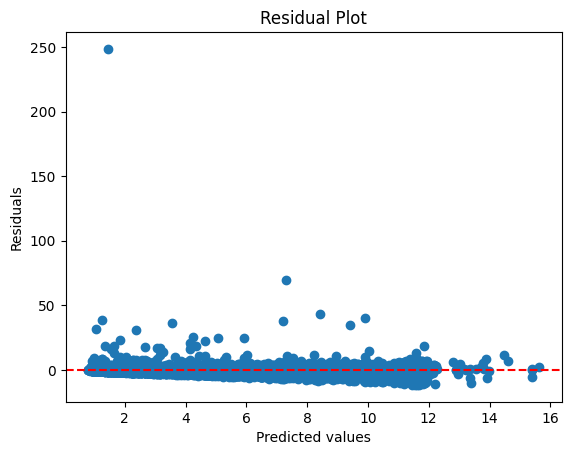

0.5534615690416523

In [2003]:
pred=rf_regressor.predict(X_test)
plot_residuals(rf_regressor,X_test,y_test)
from sklearn.metrics import mean_absolute_error
mean_absolute_error(pred,y_test)

## for percenatage

In [1891]:
pred=rf_regressor.predict(X_test)
converted = pred * X_test['fare_amount']
converted_test = y_test * X_test['fare_amount']
mean_absolute_error(converted,converted_test)

0.5537861041023975

## test

In [1892]:
test = pd.read_csv('cleaned_test.csv')
test.drop('pair',axis=1,inplace=True)
test.shape

(147546, 16)

In [1893]:
pickup_mask = (test["pickup_longitude"] > -73.79) &  (test["pickup_longitude"] < -73.76 ) &  (test["pickup_latitude"] > 40.6 ) &  (test["pickup_latitude"] <40.66  )
airport_pickup = test.loc[(test["fare_amount"] == 52) & (pickup_mask)]

JFK_min_long = min(airport_pickup["pickup_longitude"])
JFK_max_long = max(airport_pickup["pickup_longitude"])
JFK_min_lat = min(airport_pickup["pickup_latitude"])
JFK_max_lat = max(airport_pickup["pickup_latitude"])

airport_pickup_dropoff_mask =  ((test["pickup_longitude"] >= JFK_min_long) & (test["pickup_longitude"] <= JFK_max_long) &  (test["pickup_latitude"] >= JFK_min_lat ) &  (test["pickup_latitude"] <= JFK_max_lat)) |(test["dropoff_longitude"] > JFK_min_long) & (test["dropoff_longitude"] < JFK_max_long) &  (test["dropoff_latitude"] > JFK_min_lat ) &  (test["dropoff_latitude"] <JFK_max_lat)
manhattan_airport =  ((test["pickup_longitude"] >= JFK_min_long) & (test["pickup_longitude"] <= JFK_max_long) &  (test["pickup_latitude"] >= JFK_min_lat )  &  (test["pickup_latitude"] <= JFK_max_lat) & (test['dropoff_boro_code'] == 'Manhattan')) | ((test["dropoff_longitude"] >= JFK_min_long) & (test["dropoff_longitude"] <= JFK_max_long) &  (test["dropoff_latitude"] >= JFK_min_lat ) &  (test["dropoff_latitude"] <= JFK_max_lat) & (test['pickup_boro_code'] == 'Manhattan')).astype(int)
manhattan_airport2 = ((test['pickup_boro_code'] == 'Manhattan')&(test['dropoff_boro_code'] == 'Queens')&(test['fare_amount'] == 52))|((test['pickup_boro_code'] == 'Queens')&(test['dropoff_boro_code'] == 'Manhattan')&(test['fare_amount'] == 52)) | ((test['pickup_boro_code'] == 'Manhattan')&(test['trip_distance'] < 8)&(test['fare_amount'] == 52))|((test['pickup_boro_code'] == 'Queens')&(test['trip_distance'] < 8)&(test['fare_amount'] == 52))
#manhattan_airport = ((test['pickup_boro_code'] == 'Manhattan')&(test['trip_distance'] == 0)&(test['fare_amount'] == 52))|((test['pickup_boro_code'] == 'Queens')&(test['trip_distance'] == 0)&(test['fare_amount'] == 52))

In [1894]:
test['manhattan_airport'] = manhattan_airport2.astype(int)

Fix the distance and time:

In [1895]:
manhattan_median = test[manhattan_airport2]['trip_distance'].median()
mask = (test['manhattan_airport'] == 1) & (test['trip_distance'] < 8)

# Then, use loc to assign values to the selected rows
test.loc[mask, 'trip_distance'] = manhattan_median

In [1896]:
manhattan_median_l = test[manhattan_airport2]['length_time'].median()
mask = (test['manhattan_airport'] == 1) & (test['length_time'] <= 1000)

test.loc[mask, 'length_time'] = manhattan_median_l

Create new codes:

In [1897]:
new_pickup_scaled = pickup_scaler.transform(test[['pickup_latitude', 'pickup_longitude']])
new_dropoff_scaled = dropoff_scaler.transform(test[['dropoff_latitude', 'dropoff_longitude']])


test['pickup_codes'] = pickup_kmeans.predict(new_pickup_scaled)
test['dropoff_codes'] = dropoff_kmeans.predict(new_dropoff_scaled)

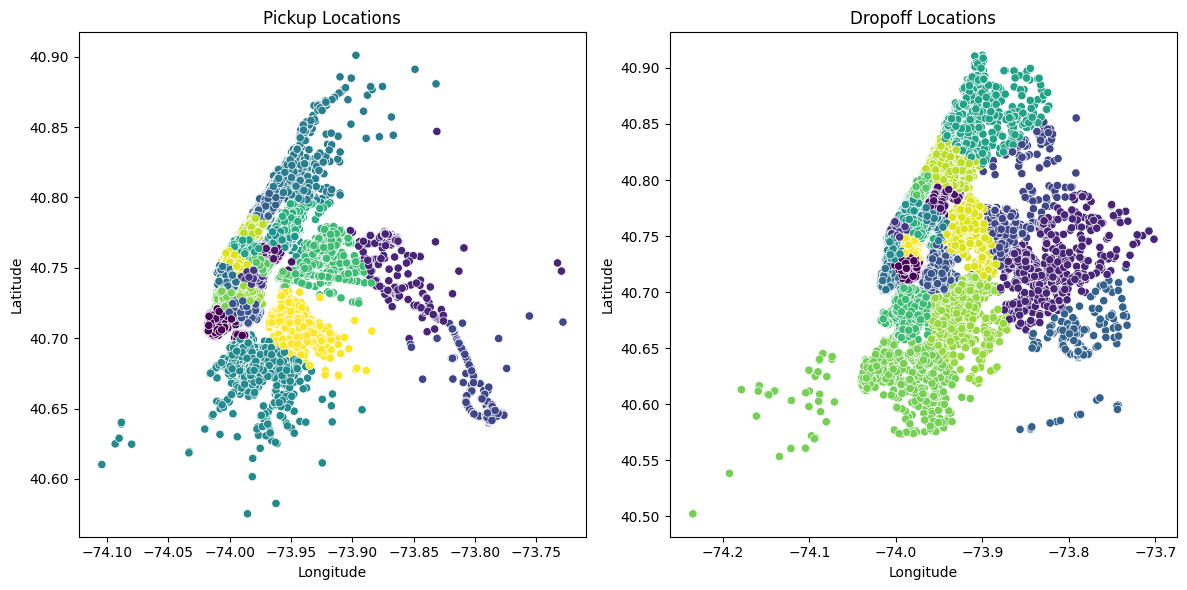

In [1898]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Scatter plot for pickup locations
sns.scatterplot(x='pickup_longitude', y='pickup_latitude', hue='pickup_codes', palette='viridis', data=test, ax=axes[0])
axes[0].set_xlabel('Longitude')
axes[0].set_ylabel('Latitude')
axes[0].set_title('Pickup Locations')
axes[0].legend().remove()  # Remove legend to avoid redundancy

# Scatter plot for dropoff locations
sns.scatterplot(x='dropoff_longitude', y='dropoff_latitude', hue='dropoff_codes', palette='viridis', data=test, ax=axes[1])
axes[1].set_xlabel('Longitude')
axes[1].set_ylabel('Latitude')
axes[1].set_title('Dropoff Locations')
axes[1].legend().remove()  # Remove legend to avoid redundancy

# Adjust layout
plt.tight_layout()

# Show plots
plt.show()

In [1899]:
test.drop(['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'pickup_boro_code', 'pickup_nta_code',
       'dropoff_boro_code', 'dropoff_nta_code'], axis=1, inplace=True)

In [1900]:
test.head()

,length_time,vendor_id,passenger_count,trip_distance,fare_amount,pickup_datetime,pickup_week,pickup_wday,manhattan_airport,pickup_codes,dropoff_codes
0,807,2,1,2.27,10.5,2015-05-25 07:00:00,22,Monday,0,10,12
1,1458,1,1,3.20,18.0,2015-05-22 00:00:00,21,Friday,0,15,5
2,495,1,1,3.40,12.0,2015-05-05 23:00:00,19,Tuesday,0,5,5
3,941,2,2,2.93,13.0,2015-05-14 19:00:00,20,Thursday,0,3,1
4,141,2,1,0.47,3.5,2015-05-02 20:00:00,18,Saturday,0,5,0


Create dummies:

In [1901]:
test['pickup_datetime'] = pd.to_datetime(test['pickup_datetime'])

# Create dummy variables for day of week
day_of_week_dummies = pd.get_dummies(test['pickup_datetime'].dt.day_name(), prefix='day')

# Create dummy variables for hour of day
hour_dummies = pd.get_dummies(test['pickup_datetime'].dt.hour, prefix='hour')

#code dummies
pickup_dummies = pd.get_dummies(test['pickup_codes'], prefix='pickup')
dropoff_dummies = pd.get_dummies(test['dropoff_codes'], prefix='dropoff')


# Concatenate the dummy variables with the original dataframe
test = pd.concat([test, day_of_week_dummies, hour_dummies, pickup_dummies, dropoff_dummies], axis=1)

#change type
test[day_of_week_dummies.columns] = test[day_of_week_dummies.columns].astype(int)
test[hour_dummies.columns] = test[hour_dummies.columns].astype(int)
test[pickup_dummies.columns] = test[pickup_dummies.columns].astype(int)
test[dropoff_dummies.columns] = test[dropoff_dummies.columns].astype(int)

test.drop(['pickup_datetime', 'pickup_wday', 'pickup_codes', 'dropoff_codes'], axis=1, inplace=True)

In [1902]:
test

,length_time,vendor_id,passenger_count,trip_distance,fare_amount,pickup_week,manhattan_airport,day_Friday,day_Monday,day_Saturday,day_Sunday,day_Thursday,day_Tuesday,day_Wednesday,hour_0,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,hour_9,hour_10,hour_11,hour_12,hour_13,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23,pickup_0,pickup_1,pickup_2,pickup_3,pickup_4,pickup_5,pickup_6,pickup_7,pickup_8,pickup_9,pickup_10,pickup_11,pickup_12,pickup_13,pickup_14,pickup_15,pickup_16,pickup_17,pickup_18,pickup_19,dropoff_0,dropoff_1,dropoff_2,dropoff_3,dropoff_4,dropoff_5,dropoff_6,dropoff_7,dropoff_8,dropoff_9,dropoff_10,dropoff_11,dropoff_12,dropoff_13,dropoff_14,dropoff_15,dropoff_16,dropoff_17,dropoff_18,dropoff_19
0,807,2,1,2.27,10.5,22,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1,1458,1,1,3.20,18.0,21,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,495,1,1,3.40,12.0,19,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,941,2,2,2.93,13.0,20,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,141,2,1,0.47,3.5,18,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147541,2355,2,5,5.28,27.0,20,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
147542,824,1,2,1.50,10.0,21,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
147543,524,1,1,1.70,8.0,20,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
147544,946,2,1,1.84,11.0,19,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


Add outlier detection

In [1903]:
data = test.copy()
data = data.loc[data["length_time"] < data["length_time"].quantile(0.995)]
data = data.loc[data["length_time"] > data["length_time"].quantile(0.005)]
data = data.loc[data["trip_distance"] < data["trip_distance"].quantile(0.995)]
data = data.loc[data["trip_distance"] > data["trip_distance"].quantile(0.005)]
data = data.loc[data["fare_amount"] < data["fare_amount"].quantile(0.995)]
data = data.loc[data["fare_amount"] > data["fare_amount"].quantile(0.005)]

In [1904]:
X = data[["trip_distance", "length_time"]]
y = data["fare_amount"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

model.coef_#
#model.intercept_

test['predicted_fare'] = test['trip_distance']*model.coef_[0] + test['length_time']*model.coef_[1] + model.intercept_
test['pred_diff'] = test['predicted_fare'] - test['fare_amount']

In [1905]:
lower_quantile = test['pred_diff'].quantile(0.01)
upper_quantile = test['pred_diff'].quantile(0.99)

# Apply the condition: Exclude extreme 'pred_diff' quantiles unless it's an airport ride
#df = df.loc[((df['pred_diff'] > lower_quantile) & (df['pred_diff'] < upper_quantile)) | (df['manhattan_airport'] == 1)]
test['is_outlier'] = ((test['pred_diff'] < lower_quantile) | (test['pred_diff'] > upper_quantile)) & (test['manhattan_airport'] != 1).astype(int)
test['pred_diff'].describe()

count    147546.000000
mean          4.055123
std        1359.919328
min        -222.705830
25%          -0.259179
50%           0.013116
75%           0.283829
max      522332.300832
Name: pred_diff, dtype: float64

In [1906]:
test.sort_values('pred_diff', ascending=True).head(10)

,length_time,vendor_id,passenger_count,trip_distance,fare_amount,pickup_week,manhattan_airport,day_Friday,day_Monday,day_Saturday,day_Sunday,day_Thursday,day_Tuesday,day_Wednesday,hour_0,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,hour_9,hour_10,hour_11,hour_12,hour_13,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23,pickup_0,pickup_1,pickup_2,pickup_3,pickup_4,pickup_5,pickup_6,pickup_7,pickup_8,pickup_9,pickup_10,pickup_11,pickup_12,pickup_13,pickup_14,pickup_15,pickup_16,pickup_17,pickup_18,pickup_19,dropoff_0,dropoff_1,dropoff_2,dropoff_3,dropoff_4,dropoff_5,dropoff_6,dropoff_7,dropoff_8,dropoff_9,dropoff_10,dropoff_11,dropoff_12,dropoff_13,dropoff_14,dropoff_15,dropoff_16,dropoff_17,dropoff_18,dropoff_19,predicted_fare,pred_diff,is_outlier
95875,41,2,3,0.00,225.0,19,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,2.294170,-222.705830,True
51667,40,2,2,0.00,200.0,20,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2.287935,-197.712065,True
77677,94,1,1,0.00,120.0,22,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2.624644,-117.375356,True
61433,61,1,1,0.00,100.0,18,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2.418877,-97.581123,True
116878,28,2,1,0.41,80.0,20,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,2.967202,-77.032798,True
26615,20,1,1,1.40,80.0,21,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,4.738175,-75.261825,True
87538,40,1,1,0.00,77.0,19,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,2.287935,-74.712065,True
125744,8,2,4,0.00,70.0,19,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2.088403,-67.911597,True
32848,26,1,3,0.90,70.0,19,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3.855963,-66.144037,True
102935,19,1,1,0.10,67.0,20,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,2.340917,-64.659083,True


treat airport:

In [1907]:
mask = (test['is_outlier'] == 1) & (test['fare_amount'] == 52)

test.loc[mask, 'trip_distance'] = manhattan_median
test.loc[mask, 'length_time'] = manhattan_median_l
test.loc[mask, 'manhattan_airport'] = 1

Treat outliers

In [1908]:
fare_bins = np.linspace(0, 225, 46)
fare_labels = [f"{fare}-{fare+5}" for fare in range(0, 225, 5)]
test['fare_bin'] = pd.cut(test['fare_amount'], bins=fare_bins, labels=fare_labels)

grouped_dists = test[test['is_outlier']==0].groupby('fare_bin')['trip_distance'].mean()
grouped_time = test[test['is_outlier']==0].groupby('fare_bin')['length_time'].mean()

outliers = test[test['is_outlier']==1]

for index, row in outliers.iterrows():
    fare_bin = row['fare_bin']
    # Impute trip_distance
    test.at[index, 'trip_distance'] = grouped_dists[fare_bin]
    # Impute length_time
    test.at[index, 'length_time'] = grouped_time[fare_bin]

/var/folders/g4/slhwkckn3v3cq27lv89msl1r0000gn/T/ipykernel_21717/1311100088.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_dists = test[test['is_outlier']==0].groupby('fare_bin')['trip_distance'].mean()
/var/folders/g4/slhwkckn3v3cq27lv89msl1r0000gn/T/ipykernel_21717/1311100088.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_time = test[test['is_outlier']==0].groupby('fare_bin')['length_time'].mean()
/var/folders/g4/slhwkckn3v3cq27lv89msl1r0000gn/T/ipykernel_21717/1311100088.py:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of p

In [1909]:
test.sort_values('pred_diff', ascending=True).head(10)

,length_time,vendor_id,passenger_count,trip_distance,fare_amount,pickup_week,manhattan_airport,day_Friday,day_Monday,day_Saturday,day_Sunday,day_Thursday,day_Tuesday,day_Wednesday,hour_0,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,hour_9,hour_10,hour_11,hour_12,hour_13,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23,pickup_0,pickup_1,pickup_2,pickup_3,pickup_4,pickup_5,pickup_6,pickup_7,pickup_8,pickup_9,pickup_10,pickup_11,pickup_12,pickup_13,pickup_14,pickup_15,pickup_16,pickup_17,pickup_18,pickup_19,dropoff_0,dropoff_1,dropoff_2,dropoff_3,dropoff_4,dropoff_5,dropoff_6,dropoff_7,dropoff_8,dropoff_9,dropoff_10,dropoff_11,dropoff_12,dropoff_13,dropoff_14,dropoff_15,dropoff_16,dropoff_17,dropoff_18,dropoff_19,predicted_fare,pred_diff,is_outlier,fare_bin
95875,NaN,2,3,NaN,225.0,19,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,2.294170,-222.705830,True,220-225
51667,NaN,2,2,NaN,200.0,20,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2.287935,-197.712065,True,195-200
77677,NaN,1,1,NaN,120.0,22,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2.624644,-117.375356,True,115-120
61433,NaN,1,1,NaN,100.0,18,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2.418877,-97.581123,True,95-100
116878,4893.833333,2,1,23.795000,80.0,20,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,2.967202,-77.032798,True,75-80
26615,4893.833333,1,1,23.795000,80.0,21,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,4.738175,-75.261825,True,75-80
87538,4893.833333,1,1,23.795000,77.0,19,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,2.287935,-74.712065,True,75-80
125744,4017.538462,2,4,21.611154,70.0,19,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2.088403,-67.911597,True,65-70
32848,4017.538462,1,3,21.611154,70.0,19,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3.855963,-66.144037,True,65-70
102935,4017.538462,1,1,21.611154,67.0,20,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,2.340917,-64.659083,True,65-70


In [1910]:
test.drop(['predicted_fare', 'pred_diff', 'fare_bin'], axis=1, inplace=True)

# prediction

In [1911]:
result = pd.Series(rf_regressor.predict(test))

In [1912]:
result

0         0.215181
1         0.213580
2         0.221008
3         0.211564
4         0.275600
            ...   
147541    0.206384
147542    0.214938
147543    0.218527
147544    0.214543
147545    0.246965
Length: 147546, dtype: float64

In [1913]:
final_result = result * test['fare_amount']

In [1914]:
final_result

0         2.259396
1         3.844443
2         2.652097
3         2.750337
4         0.964601
            ...   
147541    5.572361
147542    2.149377
147543    1.748217
147544    2.359978
147545    1.358310
Length: 147546, dtype: float64

In [648]:
len(result)

147546

make sure to change final_result to result depending on what you are predicting.

In [1915]:
final_result.to_csv("result_kuba_outliers_per.txt",sep="\t", index=False,header=False)